# **Proof of Conecpt**

imports

In [106]:
# general 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import datetime
import json
from scipy.stats import skewnorm
import seaborn as sns
# ml 
import torch 
# my modules 
import coinbase_order_functions as cb_trade
import dmlstm_trading as dmlstm 
# coinbase 
from coinbase.rest import RESTClient

## **Get Data**

In [ ]:
path_keys = r'your_cdp_api_json_path'
with open(path_keys) as f:
    cb_apis = json.load(f)

# get client
cb_account = cb_trade.CoinbaseTrader(api_key = cb_apis['name'], api_secret = cb_apis['privateKey'])
print('Coinbase Advanced account login status:', cb_account.login())

Coinbase Advanced account login status: True


In [12]:
# portfolio assets and benchamrk
tickers = ['BTC-GBP', 'ETH-GBP', 'SOL-GBP', 'LINK-GBP', 'ADA-GBP'] # because account in gbp, so nop conversion required when making orders 
benchmark_ticker = 'BTC-GBP'

# times 
data_frequency = "ONE_HOUR"
freq = '1h'
data_max = {'hours': 350}

# pull data 
dataset_returns = cb_account.coinbase_data(products = tickers, time_frame_candle = data_frequency, freq = freq, **data_max)
dataset_prices = cb_account.coinbase_data(products = tickers, time_frame_candle = data_frequency, get_returns = False, freq = freq, **data_max)

In [13]:
dataset_returns

,BTC-GBP,ETH-GBP,SOL-GBP,LINK-GBP,ADA-GBP
1,0.001195,0.000540,-0.001313,0.000000,0.000677
2,-0.000142,-0.001055,-0.004733,0.001274,-0.001184
3,-0.000861,0.000753,0.000396,-0.005725,0.000339
4,-0.001111,-0.002551,-0.002905,-0.001919,-0.008632
5,-0.001176,-0.005575,-0.005165,0.008333,-0.008195
...,...,...,...,...,...
345,0.001797,-0.003316,0.002833,0.002992,-0.018349
346,-0.000748,0.003491,0.007099,0.009694,0.001016
347,-0.000761,-0.004184,-0.008128,-0.005908,-0.001218
348,-0.003349,0.000212,0.004786,0.000000,0.004471


In [5]:
# check dataset shapes are equal
dataset_returns.shape == dataset_prices.shape

True

training and test sets

In [14]:
# this is our target distribution that incodes our preferences 
target_loc = 0.03
target_scale = 0.04
target_skew = 3
target_returns = skewnorm.rvs(a = target_skew, loc = target_loc, scale = target_scale, size = dataset_returns.shape[0])

# check shape dimensions match 
print("Dimensions alligned") if target_returns.shape[0] == dataset_returns.iloc[:, 0].shape[0] else print("Dimension mismatch")

Dimensions alligned


In [15]:
# features
returns_train, returns_test = dmlstm.train_test_split_time_series(data = dataset_returns, train_size = 0.65)
prices_train, prices_test = dmlstm.train_test_split_time_series(data = dataset_prices, train_size = 0.65)

# labels 
y_train, y_test = dmlstm.train_test_split_time_series(data = target_returns, train_size = 0.65)

train initial model

In [16]:
lookback = 10
# pre process data 
x_train_tensor, y_train_tensor = dmlstm.prepare_features(asset_returns = returns_train, 
                                                         asset_prices = prices_train, 
                                                         target_returns = y_train, 
                                                         lookback = lookback)

## **Instantiate Model**

In [17]:
# instantiate model
dims = returns_train.shape[1]
dmlstm_model = dmlstm.DmLSTM(input_dim = dims, output_dim = dims, hidden_dim = 64, num_layers = 2)

print("input = (batch_size = m - lookback, sequence length = m, input_size) =",  x_train_tensor.shape)

# predict model
predicted_weights = dmlstm_model(x_train_tensor) # model has little variation fro in-sample prediction, because uniform setting to all parameters
print("output = (batch_size, sequence length = lookback, hidden size) =",  predicted_weights.shape)

input = (batch_size = m - lookback, sequence length = m, input_size) = torch.Size([216, 10, 10])
output = (batch_size, sequence length = lookback, hidden size) = torch.Size([216, 5])


## **Train Model**

In [18]:
lookback = 10
res_in_sample = dmlstm.backprop_rnn(asset_returns = returns_train,
                          asset_prices = prices_train, 
                          target_returns = y_train, 
                          lookback = lookback, 
                          show_progress = True, 
                          learning_rate = 0.001, 
                          n_epochs = 100, 
                          num_layers = 2, 
                          hidden_dim = 100)

# np.round(res['trained_weights'], 3)

  8%|▊         | 8/100 [00:00<00:02, 35.84it/s]

⏳ Training progress | 0.0% | Loss = 5.416285514831543


 18%|█▊        | 18/100 [00:00<00:02, 40.08it/s]

⏳ Training progress | 10.0% | Loss = 4.170583248138428


 28%|██▊       | 28/100 [00:00<00:01, 41.34it/s]

⏳ Training progress | 20.0% | Loss = 3.77189040184021


 38%|███▊      | 38/100 [00:00<00:01, 41.96it/s]

⏳ Training progress | 30.0% | Loss = 3.5118637084960938


 48%|████▊     | 48/100 [00:01<00:01, 42.40it/s]

⏳ Training progress | 40.0% | Loss = 3.1009693145751953


 58%|█████▊    | 58/100 [00:01<00:01, 39.25it/s]

⏳ Training progress | 50.0% | Loss = 2.781003952026367


 68%|██████▊   | 68/100 [00:01<00:00, 40.99it/s]

⏳ Training progress | 60.0% | Loss = 2.69254207611084


 78%|███████▊  | 78/100 [00:01<00:00, 41.62it/s]

⏳ Training progress | 70.0% | Loss = 2.519655704498291


 88%|████████▊ | 88/100 [00:02<00:00, 42.08it/s]

⏳ Training progress | 80.0% | Loss = 2.4018032550811768


 98%|█████████▊| 98/100 [00:02<00:00, 42.38it/s]

⏳ Training progress | 90.0% | Loss = 2.2583863735198975


100%|██████████| 100/100 [00:02<00:00, 40.82it/s]

✅ Model Trained: Training Progress | 100% | Loss = 2.225423574447632


## **In-sample Training Performance**

estimated optimal in-sample weights 

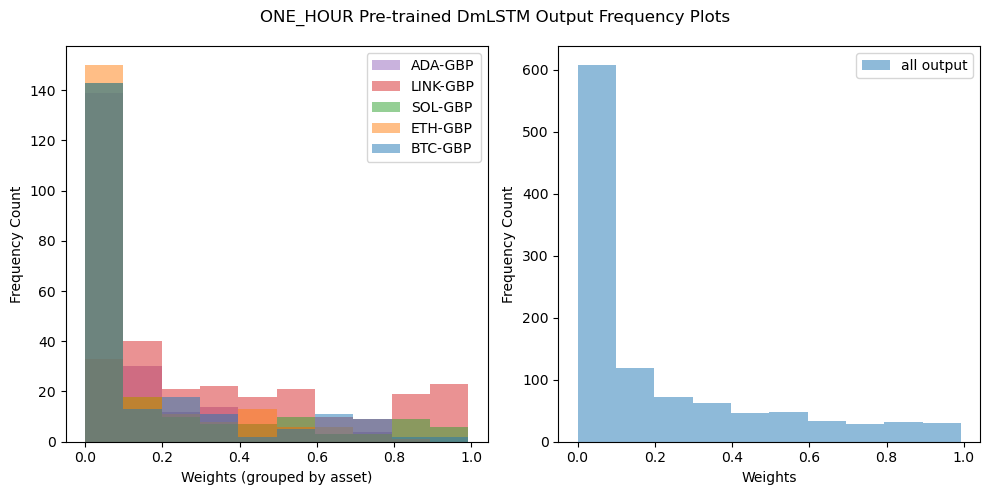

In [19]:
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize = (10, 5))
plt.suptitle(f"{data_frequency} Pre-trained DmLSTM Output Frequency Plots")
all_weights = res_in_sample['trained_weights'].reshape(-1, 1).flatten().tolist()
ax[0].hist(res_in_sample['trained_weights'], histtype = 'stepfilled', alpha = 0.5, label = tickers)
ax[0].set_xlabel('Weights (grouped by asset)')
ax[0].set_ylabel('Frequency Count')
ax[0].legend()
ax[1].hist(all_weights, histtype = 'bar', alpha = 0.5, label = 'all output')
ax[1].set_xlabel('Weights')
ax[1].set_ylabel('Frequency Count')
ax[1].legend()
plt.tight_layout();

equity curve performanc. Fees are incoporated in model [1].

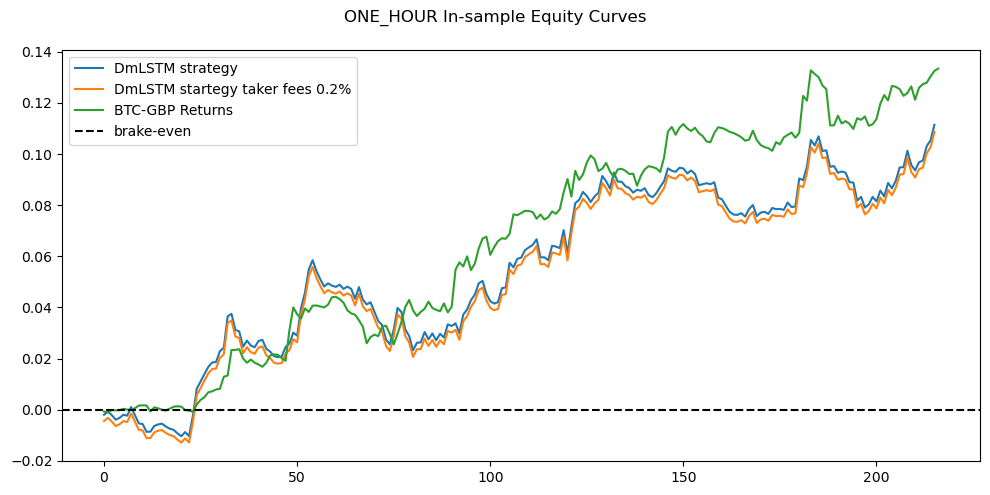

In [ ]:
def weight_rebalance(weights: np.ndarray):
    # weight diff **abstract this in equity curve function**
    prior_weights = np.zeros(shape = weights.shape)
    prior_weights[1:, :] = weights[ :-1, :] # from 1st row fill with original array not including last row 
    weight_diff = np.sum(weights - prior_weights, axis = 1)

    return weight_diff

# equity curve function
def equity_curve(returns: np.ndarray, weights, fees = False, fee = 0):
    weight_diff_fees = weight_rebalance(weights)*fee if fees else fee 
    log_returns = np.log(1 + returns - weight_diff_fees)
    sum = np.cumsum(log_returns)
    final_returns = np.exp(sum) -1 

    return final_returns

# equity curves 
in_sample_equity_curve = equity_curve(res_in_sample['predicted_returns'], weights = res_in_sample['trained_weights'])
in_sample_equity_curve_fees = equity_curve(res_in_sample['predicted_returns'], weights = res_in_sample['trained_weights'], fees = True, fee = 0.25/100)
in_sample_benchmark_equity_curve = equity_curve(dataset_returns.loc[lookback:len(returns_train), benchmark_ticker].values, weights = res_in_sample['trained_weights'])

# plot 
fig, ax = plt.subplots(figsize = (10, 5))
fig.suptitle(f"{data_frequency} In-sample Equity Curves")
ax.plot(in_sample_equity_curve, label = "DmLSTM strategy")
ax.plot(in_sample_equity_curve_fees, label = "DmLSTM startegy taker fees 0.2%")
ax.plot(in_sample_benchmark_equity_curve, label = f"{benchmark_ticker} Returns")
ax.axhline(0, color = 'black', linestyle = "--", label = "brake-even")
ax.legend()
fig.tight_layout();

## **Grid Search**

2 parameter grid search for 
* dimension
* sequence = lookback


In [22]:
hidden_dims = range(50, 325, 25)
# learning_rates = np.linspace(start = 0.001, stop = 0.01, num = 10) # number of samples to generate
# range subsets are inclusive
lookbacks = range(3, 13)
# toal grid search params = num * lookbacks-1 * (start - end)/step

In [ ]:
# get list of dictionaries with parameters
def grid_search_params(return_data, price_data, target_returns, hidden_dims, lookbacks):
    training_params = []
    for hd in hidden_dims:
        for lkb in lookbacks:
            training_params.append(
                {
                    "asset_returns": return_data,
                    "asset_prices": price_data, 
                    "target_returns": target_returns,
                    "lookback": lkb, 
                    "show_progress": False, 
                    "learning_rate": 0.01, 
                    "n_epochs": 100, 
                    "num_layers": 3, 
                    "hidden_dim": hd, 
                }
            )
    
    return training_params

training_params = grid_search_params(returns_train, prices_train, y_train, hidden_dims, lookbacks)

# map function to input iterbale
def run_grid_search(training_params):
    return list(map(lambda input: dmlstm.backprop_rnn(**input), training_params))

# get final returns 
def get_key(return_key, grid_search_output, fees = False, fee = 0):
    final_returns = []
    for res in grid_search_output:
        final_returns.append(
            equity_curve(res[return_key], weights = None, fees = fees, fee = fee)[-1] # get last cumulative return (ROR)
        )
    
    return final_returns


In [24]:
# unique models 
print('models to train:', len(training_params))

models to train: 110


run grid search

In [ ]:
# run grid search 
res = run_grid_search(training_params)

100%|██████████| 100/100 [00:12<00:00,  8.26it/s]


get final returns 

In [22]:
# get final returns
cb_tacker_fee_adv1 = 0.25 / 100
final_returns = get_key('predicted_returns', res, weight_diff = None, fees = False, fee = cb_tacker_fee_adv1)

plot grid search output 

In [23]:
hidden_list = [i for i in hidden_dims for j in lookbacks] # loop lookback times and print learning rate 
lookbacks_list = np.array(lookbacks).tolist() * len(hidden_dims) # repeat for lookback times 

In [43]:
benchmark_final_return = equity_curve(returns_train)[-1]
alpha = final_returns - benchmark_final_return

In [44]:
grid_search = pd.DataFrame({'hidden_layers': hidden_list,
                            'lookbacks': lookbacks_list, 
                            'final_returns': final_returns, 
                            'alpha': alpha})

# get dataset pf final return values
grid_search_final_return = grid_search.pivot(index = 'hidden_layers', columns = 'lookbacks', values = 'final_returns') # aggragets by index and column
grid_search_alpha = grid_search.pivot(index = 'hidden_layers', columns = 'lookbacks', values = 'alpha')

NaN values are from insufficient lookback window to standardise, min data required to standardise is 2, so set lookbacks to search from 2 onwards 

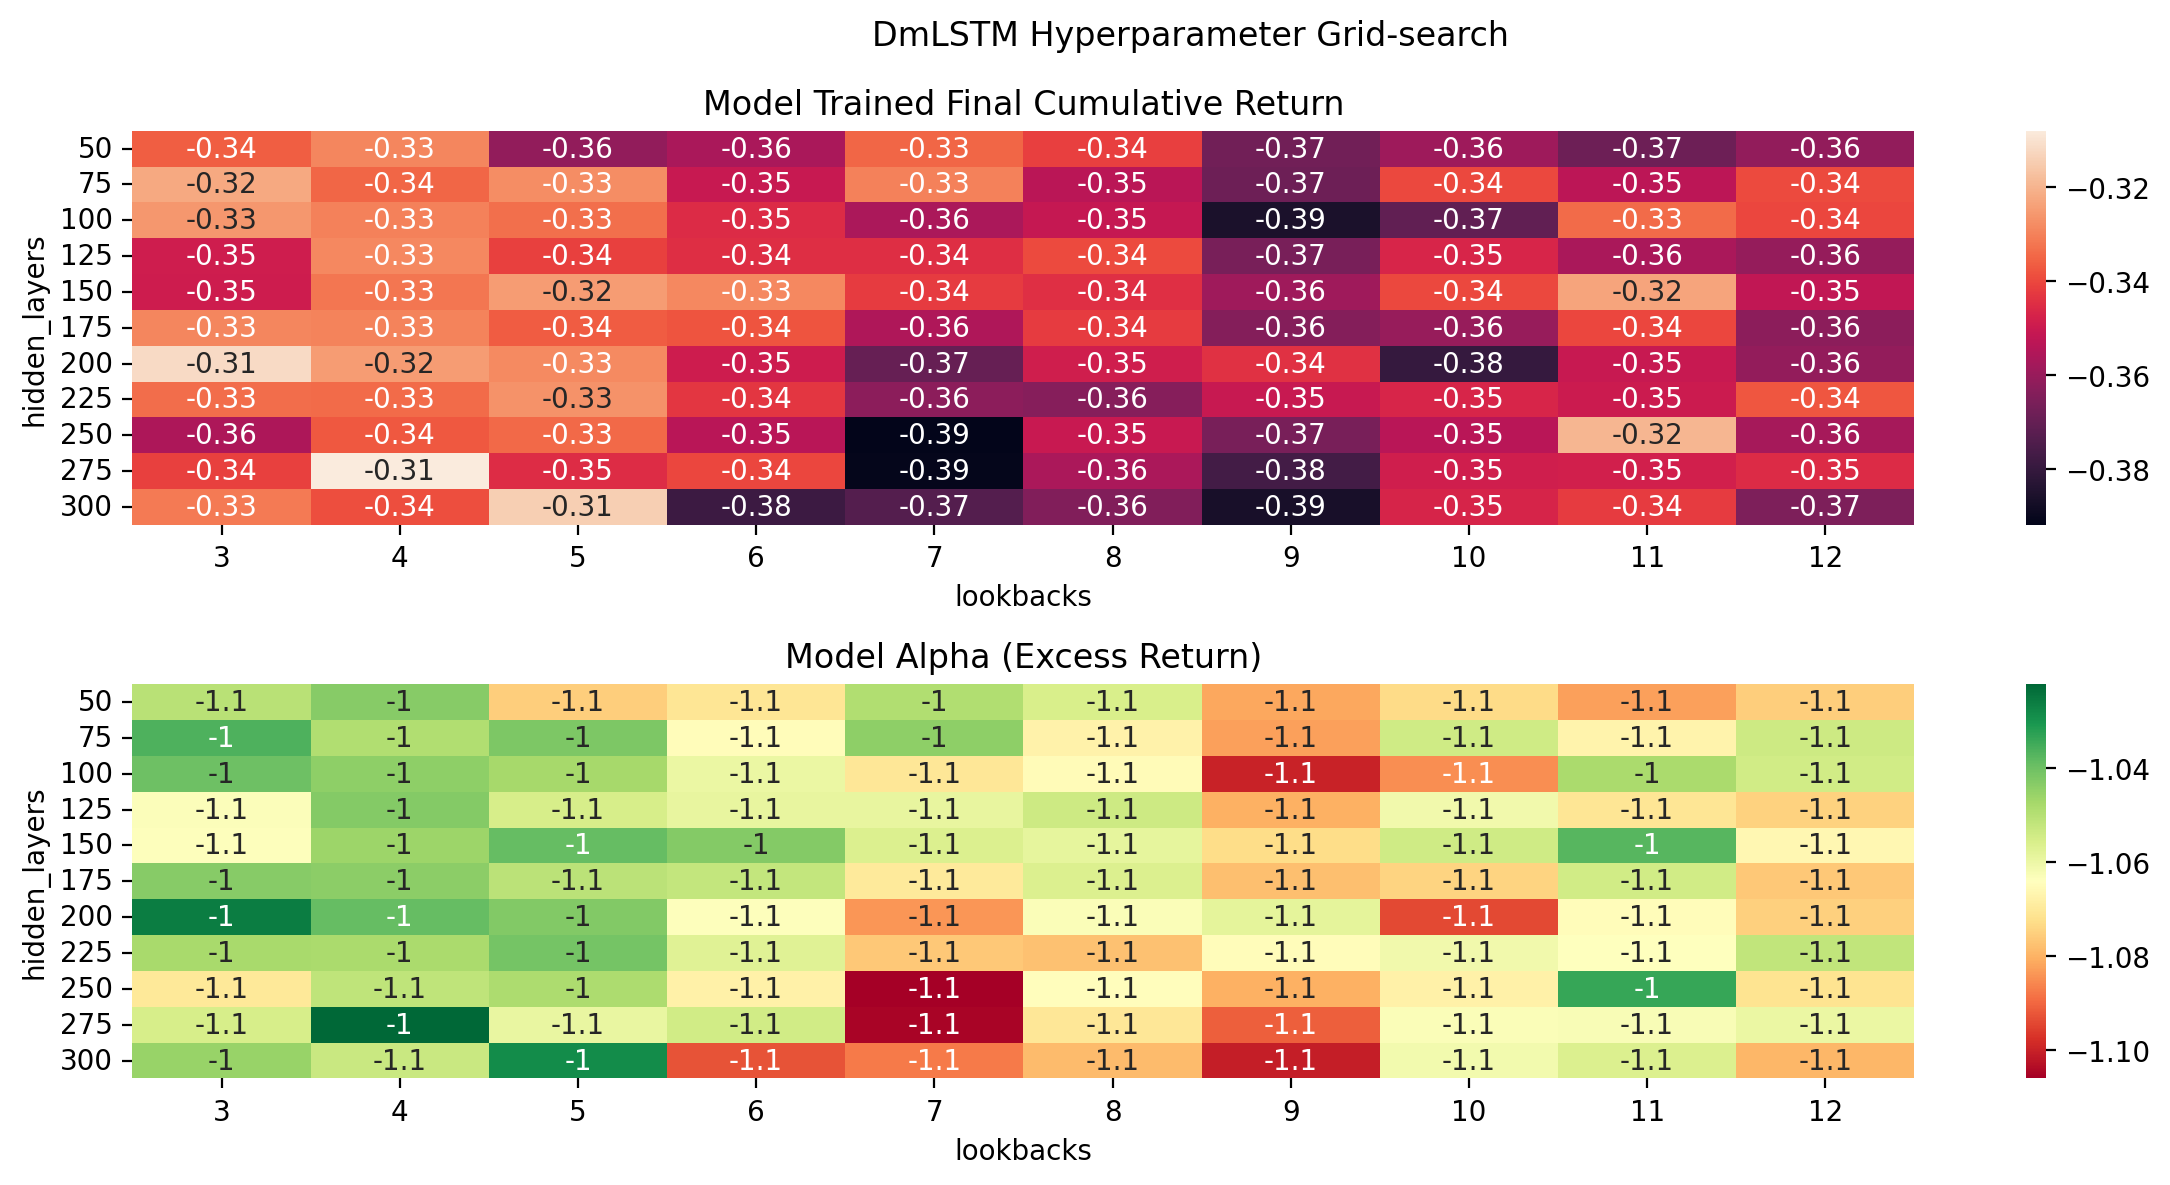

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6), dpi = 200)
fig.suptitle("DmLSTM Hyperparameter Grid-search")
sns.heatmap(grid_search_final_return, annot = True, ax = ax[0])
ax[0].set_title('Model Trained Final Cumulative Return')
sns.heatmap(grid_search_alpha, annot = True, ax = ax[1], cmap = 'RdYlGn')
ax[1].set_title('Model Alpha (Excess Return)')
plt.tight_layout();

## **Single Timeframe Grid-search Model Prediction**

load best performing model from grid search and use it to make predictions on unseen data 

optimal LSTM settings:
* hidden dimensions = []
* lookbacks = []

In [ ]:
# chosen params
hidden_dim = 50 
lookback = 4

# get model index with these params 
model_number = None
for indx1, model in enumerate(training_params):
    if training_params[indx1]['hidden_dim'] == hidden_dim and training_params[indx1]['lookback'] == lookback:
        model_number = indx1

# confirm 
print(training_params[model_number]['hidden_dim'])
print(training_params[model_number]['lookback'])

# get 'optimal' model using index 
dmlstm_opt = res[model_number]['trained_model']  
print(dmlstm_opt)

50
4
DmLSTM(
  (lstm): LSTM(10, 50, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=50, out_features=5, bias=True)
  (output): Softmax(dim=-1)
)


get model and predict 

In [52]:
# pre-process data
x_test_tensor, y_test_tensor = dmlstm.prepare_features(asset_returns = returns_test, 
                                                         asset_prices = prices_test, 
                                                         target_returns = y_test, 
                                                         lookback = 4)

# pass batch data to forward method of model 
validation_weights = dmlstm_opt(x_test_tensor).detach().numpy() # model already instantiated, now just load model

# model asset allocation
# np.round(validation_weights, 3)

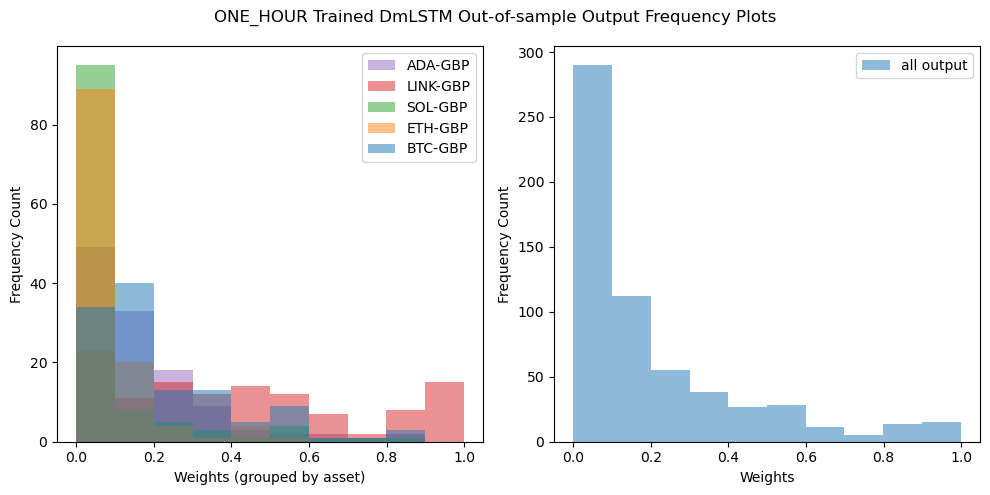

In [53]:
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize = (10, 5))
plt.suptitle(f"{data_frequency} Trained DmLSTM Out-of-sample Output Frequency Plots")
all_weights = validation_weights.reshape(-1, 1).flatten().tolist()
ax[0].hist(validation_weights, histtype = 'stepfilled', alpha = 0.5, label = tickers)
ax[0].set_xlabel('Weights (grouped by asset)')
ax[0].set_ylabel('Frequency Count')
ax[0].legend()
ax[1].hist(all_weights, histtype = 'bar', alpha = 0.5, label = 'all output')
ax[1].set_xlabel('Weights')
ax[1].set_ylabel('Frequency Count')
ax[1].legend()
plt.tight_layout();

## **Single Timeframe Out-of-sample Performance**

to model fees correctley we need to find the fraction of fees from the portfolio weight change per new model prediction and subtract this from the weighted return.

In [54]:
# change first value in returns array to zero/fee value. When strategy beggins trading, this value is not know (avoid forward leak)
returns_test_subset = returns_test[lookback:]
returns_test_subset[0] = -0.35/100 # average of fees (forcasted)

# calculate 
out_sample_returns = np.sum(validation_weights * returns_test_subset, axis = 1)

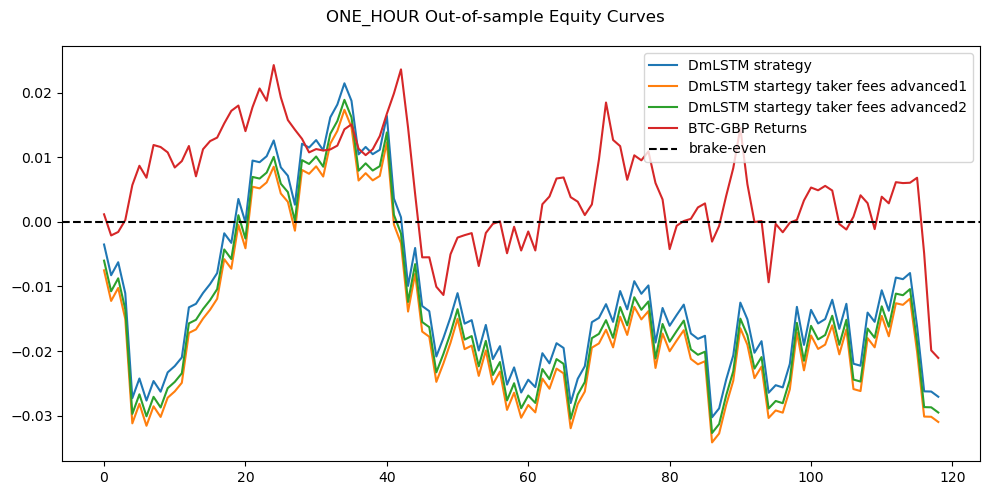

In [56]:
# equity curves 
val_equity_curve = equity_curve(out_sample_returns, weights=validation_weights)
val_equity_curve_fees1 = equity_curve(out_sample_returns, weights = validation_weights, fees = True, fee = 0.40/100)
val_equity_curve_fees2 = equity_curve(out_sample_returns, weights = validation_weights, fees = True, fee = 0.25/100)
benchmark_ticker = 'BTC-GBP'
val_benchmark_equity_curve = equity_curve(dataset_returns.loc[len(returns_train) + 1+lookback:, benchmark_ticker].values, weights = validation_weights)

# plot 
fig, ax = plt.subplots(figsize = (10, 5))
fig.suptitle(f"{data_frequency} Out-of-sample Equity Curves")
ax.plot(val_equity_curve, label = "DmLSTM strategy")
ax.plot(val_equity_curve_fees1, label = "DmLSTM startegy taker fees advanced1")
ax.plot(val_equity_curve_fees2, label = "DmLSTM startegy taker fees advanced2")
ax.plot(val_benchmark_equity_curve, label = f"{benchmark_ticker} Returns")
ax.axhline(0, color = 'black', linestyle = "--", label = "brake-even")
ax.legend()
fig.tight_layout();

## **Time Frame Grid Search**

In [38]:
# times 
data_frequency = ["FIVE_MINUTE", "FIFTEEN_MINUTE", "ONE_HOUR", "FOUR_HOUR", "ONE_DAY"] # coinbase data length []

freq = ['5min', '15min', '1h', '4h', 'D'] # pd.date_range() date frequency 

data_max = [ 
    {'minutes': 350*5},
    {'minutes': 350*15}, 
    {'hours': 350},
    {'hours': 350*4}, 
    {'days': 350}
] 

# params to search
hidden_dims = range(50, 275, 25)
lookbacks = range(3, 11)

In [74]:
print('total number of simulations in multi-timeframe grid search =', len(hidden_dims) * len(lookbacks) * len(data_frequency))

total number of simulations in multi-timeframe grid search = 360


In [58]:
def run_grid_search_multi_timeframe(target_returns: np.ndarray, data_frequency: list, freq: list, data_max: list, 
                                    hidden_dims: range, lookbacks: range):
    # initilse params for grid search
    grid_search_returns, grid_search_alpha = [], []

    for timeframe in range(len(data_frequency)):

        # get return and price data 
        data_returns = cb_account.coinbase_data(products = tickers, time_frame_candle = data_frequency[timeframe], get_returns = True, 
                                                freq = freq[timeframe], **data_max[timeframe])
        data_prices = cb_account.coinbase_data(products = tickers, time_frame_candle = data_frequency[timeframe], get_returns = False, 
                                                freq = freq[timeframe], **data_max[timeframe])
        # split data
        training_set_split = 0.65
        returns_train, returns_test = dmlstm.train_test_split_time_series(data = data_returns, train_size = training_set_split)
        prices_train, prices_test = dmlstm.train_test_split_time_series(data = data_prices, train_size = training_set_split)
        target_returns_train, target_returns_test = dmlstm.train_test_split_time_series(data = target_returns, train_size = training_set_split)
        
        # grid search 
        training_params = grid_search_params(return_data = returns_train, price_data = prices_train, target_returns = target_returns_train,
                                              hidden_dims = hidden_dims, lookbacks = lookbacks)
        res = run_grid_search(training_params = training_params) # runs grid search on model
        final_returns = get_key(return_key = 'predicted_returns', weight_key = 'trained_weights', grid_search_output = res) # gets model portfolio return estimate and calculates final return 
        grid_search_returns.append(final_returns)

        # construct final return and alpha dataframes
        benchmark_final_return = equity_curve(returns = returns_train, weights = None)[-1]
        alpha = final_returns - benchmark_final_return
        grid_search_alpha.append(alpha)
    
    return {'grid_search_final_returns': grid_search_returns, 
            'grid_search_excess_returns': grid_search_alpha}

In [83]:
def grid_search_to_dataframe(hidden_dimentions, lookbacks, final_returns, alphas):  
    # list of all tested params 
    hidden_list = [i for i in hidden_dimentions for j in lookbacks] # loop lookback times and print learning rate 
    lookbacks_list = np.array(lookbacks).tolist() * len(hidden_dimentions) # repeat lookback hidden_list times  

    grouped_final_returns, grouped_alpha = [], []
    for grid_search in range(len(final_returns)):
        # construct final return and alpha dataframe
        grid_search_df = pd.DataFrame({'hidden_layers': hidden_list,
                                'lookbacks': lookbacks_list, 
                                'final_returns': final_returns[grid_search], 
                                'alpha': alphas[grid_search]})
        
        # get dataset of final return values
        grid_search_final_return = grid_search_df.pivot(index = 'hidden_layers', columns = 'lookbacks', values = 'final_returns') # aggragets by index and column
        grid_search_alpha = grid_search_df.pivot(index = 'hidden_layers', columns = 'lookbacks', values = 'alpha')

        grouped_final_returns.append(grid_search_final_return)
        grouped_alpha.append(grid_search_alpha)

    return {'grouped_returns': grouped_final_returns, 
            'grouped_alpha': grouped_alpha}

run multi-timeframe grid-search 

In [60]:
res = run_grid_search_multi_timeframe(target_returns = target_returns, data_frequency = data_frequency, freq = freq, 
                                      data_max = data_max, hidden_dims = hidden_dims, lookbacks = lookbacks)


100%|██████████| 100/100 [00:08<00:00, 11.60it/s]


get multi-timeframe final returns and alpha data  

In [84]:
multi_data = grid_search_to_dataframe(hidden_dimentions = hidden_dims, lookbacks = lookbacks,
                                      final_returns = res['grid_search_final_returns'], 
                                      alphas = res['grid_search_excess_returns'])

plot grid search final returns for different timeframes 

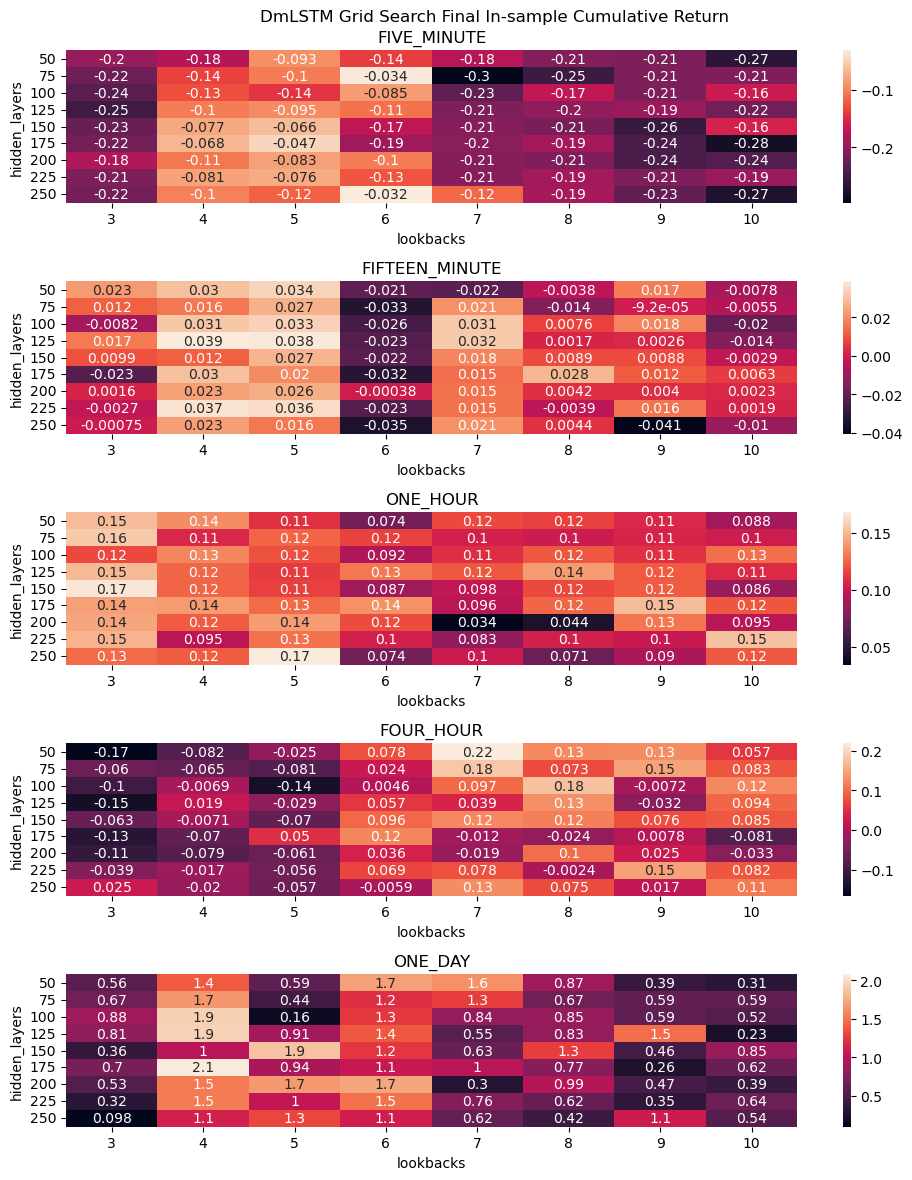

In [101]:
fig, ax = plt.subplots(nrows = len(multi_data['grouped_returns']), ncols = 1, figsize = (10, 12))
fig.suptitle('DmLSTM Grid Search Final In-sample Cumulative Return')
for idx, data in enumerate(multi_data['grouped_returns']):
    sns.heatmap(data = data, annot = True, ax = ax[idx])
    ax[idx].set_title(f'{data_frequency[idx]}')
fig.tight_layout();

plot grid search of alpha values for different timeframes 

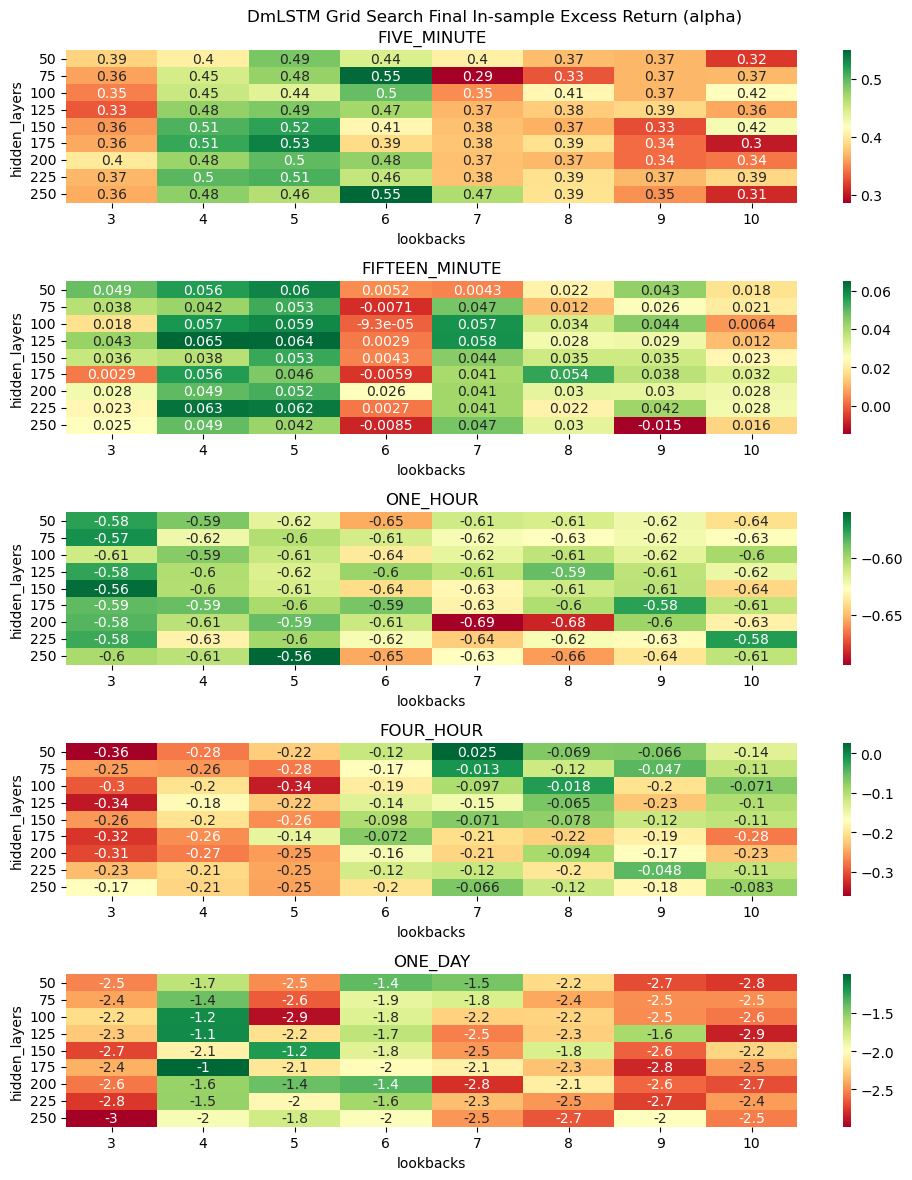

In [ ]:
fig, ax = plt.subplots(nrows = len(multi_data['grouped_alpha']), ncols = 1, figsize = (10, 12))
fig.suptitle('DmLSTM Grid Search Final In-sample Excess Return (alpha)')
for idx, data in enumerate(multi_data['grouped_alpha']):
    sns.heatmap(data = data, annot = True, cmap = "RdYlGn", ax = ax[idx])
    ax[idx].set_title(f'{data_frequency[idx]}')
fig.tight_layout();

## **Appendix**

[1] - [Coinbase Taker/Maker Spot Fees](https://www.coinbase.com/advanced-fees) $\\$